In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(0)



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)    

model_dnn_2 = nn.Sequential(Flatten(), nn.Linear(784,200), nn.ReLU(), 
                            nn.Linear(200,10)).to(device)

model_dnn_4 = nn.Sequential(Flatten(), nn.Linear(784,200), nn.ReLU(), 
                            nn.Linear(200,100), nn.ReLU(),
                            nn.Linear(100,100), nn.ReLU(),
                            nn.Linear(100,10)).to(device)

model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)


In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)



def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

0it [00:00, ?it/s]

9920512it [00:02, 4304693.29it/s]                             


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:03, 10922.43it/s]                            
0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:01, 1131459.20it/s]                           
0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 25884.74it/s]            

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [4]:
opt = optim.SGD(model_dnn_2.parameters(), lr=1e-1)
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_dnn_2, opt)
    test_err, test_loss = epoch(test_loader, model_dnn_2)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")
    
    
    
    
opt = optim.SGD(model_dnn_4.parameters(), lr=1e-1)
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_dnn_4, opt)
    test_err, test_loss = epoch(test_loader, model_dnn_4)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")
    
    
    
    
opt = optim.SGD(model_cnn.parameters(), lr=1e-1)
for t in range(10):
    train_err, train_loss = epoch(train_loader, model_cnn, opt)
    test_err, test_loss = epoch(test_loader, model_cnn)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

0.131833	0.510995	0.081200	0.286766
0.075933	0.264755	0.062600	0.220393
0.059733	0.210222	0.053800	0.182406
0.049333	0.173824	0.047700	0.158933
0.042233	0.148129	0.038800	0.136713
0.036483	0.128240	0.036700	0.123244
0.032017	0.113127	0.033400	0.112570
0.028550	0.100832	0.030500	0.102933
0.025017	0.090675	0.029900	0.100128
0.022583	0.082377	0.029700	0.099003
0.230483	0.760702	0.085500	0.281864
0.065100	0.220869	0.045500	0.151801
0.042217	0.143030	0.035800	0.117922
0.031800	0.106133	0.032200	0.105105
0.025883	0.084971	0.027300	0.086052
0.020483	0.068996	0.028600	0.091057
0.017200	0.057379	0.024700	0.078578
0.014883	0.049171	0.024600	0.077526
0.012600	0.041440	0.026500	0.085066
0.010817	0.035355	0.022400	0.076369
0.232467	0.668480	0.033300	0.103820
0.027333	0.088229	0.019600	0.066318
0.017700	0.056608	0.017000	0.052765
0.013200	0.042250	0.015900	0.045693
0.010167	0.032718	0.014700	0.047249
0.004383	0.015648	0.011200	0.036492
0.003267	0.012455	0.010900	0.036617
0.003100	0.011058	0.011000	0

In [0]:
torch.save(model_dnn_2.state_dict(), "model_dnn_2.pt")
torch.save(model_dnn_4.state_dict(), "model_dnn_4.pt")
torch.save(model_cnn.state_dict(), "model_cnn.pt")

In [0]:
import matplotlib.pyplot as plt
def fgsm(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()
  
  
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break
    
def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()
    
    


Nornal prediction of DNN


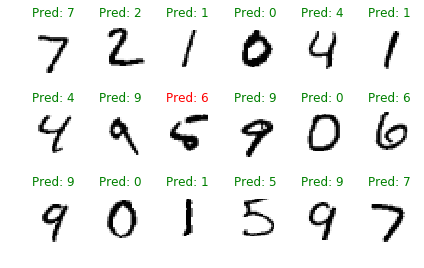

In [11]:
### Illustrate original predictions
print('Nornal prediction of DNN')
yp = model_dnn_2(X)
plot_images(X, y, yp, 3, 6)

Adversarial  prediction of DNN


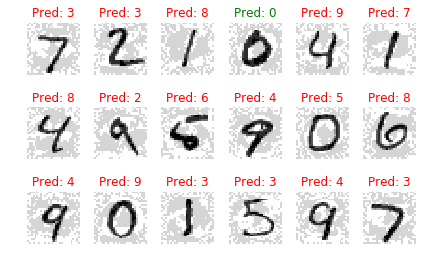

In [12]:
### Illustrate attacked images
print('Adversarial  prediction of DNN')
delta = fgsm(model_dnn_2, X, y, 0.1)
yp = model_dnn_2(X + delta)
plot_images(X+delta, y, yp, 3, 6)

Nornal prediction of CNN


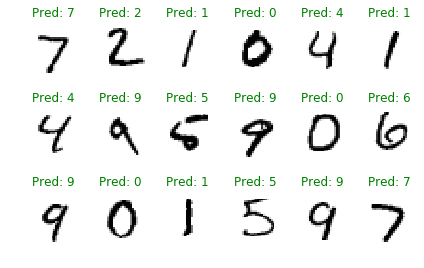

In [13]:
### Illustrate original predictions
print('Nornal prediction of CNN')
yp = model_cnn(X)
plot_images(X, y, yp, 3, 6)

Adversarial  prediction of CNN


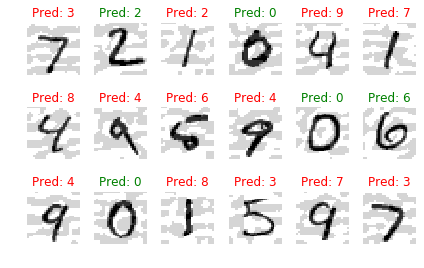

In [14]:
### Illustrate attacked images
print('Adversarial  prediction of CNN')
delta = fgsm(model_cnn, X, y, 0.1)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [15]:
def epoch_adversarial(model, loader, attack, *args):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, *args)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)
  
  
  
print("2-layer DNN:", epoch_adversarial(model_dnn_2, test_loader, fgsm, 0.1)[0])
print("4-layer DNN:", epoch_adversarial(model_dnn_4, test_loader, fgsm, 0.1)[0])
print("        CNN:", epoch_adversarial(model_cnn, test_loader, fgsm, 0.1)[0])

2-layer DNN: 0.9332
4-layer DNN: 0.8983
        CNN: 0.4693


# Targeted attack

## The outer minimization problem .........

 in this case the only difference is that instead of maximizing the loss of the true label, we maximize the loss of the loss of the true label and also minimize the loss for the alternative label.  This is equivalent to solving the inner optimization problem
\begin{equation}
\maximize_{\|\delta\| \leq \epsilon} \left ( \ell(h_\theta(x + \delta), y) - \ell(h_\theta(x + \delta), y_{\mathrm{targ}}) \right ) \equiv \maximize_{\|\delta\| \leq \epsilon} \left ( h_\theta(x + \delta)_{y_{\mathrm{targ}}} - h_\theta(x + \delta)_y \right )
\end{equation}



![alt text](https://imgur.com/YucfmuD)


In [0]:
def pgd_linf_targ(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = (yp[:,y_targ] - yp.gather(1,y[:,None])[:,0]).sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()
  




### making class label to 2

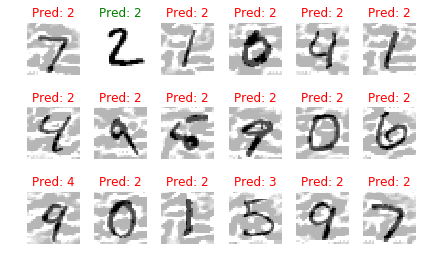

In [18]:
delta = pgd_linf_targ(model_cnn, X, y, epsilon=0.2, alpha=1e-2, num_iter=40, y_targ=2)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

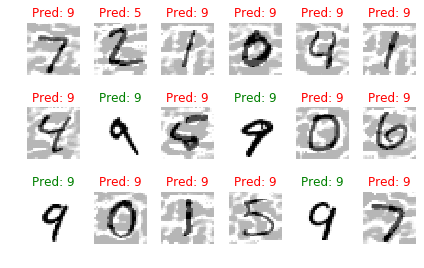

In [19]:
delta = pgd_linf_targ(model_cnn, X, y, epsilon=0.2, alpha=1e-2, num_iter=40, y_targ=9)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

While we are able to fool the classifier for all the non-zero digits, it's worth pointing out that we don't actually achieve the target class here in all cases.  This is because the optimization objective we are maximizing is the class logit for the zero minus the class logit for the true class.  But we don't actually care what happens to the other classes, and in some cases, the best way to make the class 0 logit high is to make another class logit even higher.  We can get around this by modifying our objective to maximize the target class logit and minimize _all_ the other logits, i.e.,
\begin{equation}
\maximize_{\|\delta\| \leq \epsilon} \left ( h_\theta(x + \delta)_{y_{\mathrm{targ}}} - \sum_{y' \neq y_{\mathrm{targ}}} h_\theta(x + \delta)_{y'} \right )
\end{equation}

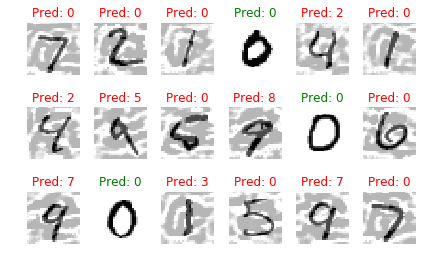

In [20]:
def pgd_linf_targ2(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = 2*yp[:,y_targ].sum() - yp.sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()
  
  
  
delta = pgd_linf_targ(model_cnn, X, y, epsilon=0.2, alpha=1e-2, num_iter=40, y_targ=0)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)